In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from random import shuffle

In [33]:
#Data Collection
collect_data = False
mode = 1
ct = 0
if collect_data:
    RiverClicks = []
    NonRiverClicks = []
    def mouse_callback(event, x, y, flags, params):
        global mode
        global ct
        if event == cv2.EVENT_LBUTTONDOWN:
            ct += 1
            print('Click ' + str(ct))
            global NonRiverClicks
            global RiverClicks
            if mode == 1:
                RiverClicks.append([x, y])
            else:
                NonRiverClicks.append([x,y])
    img = cv2.imread('images/4.png',0)
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback('image', mouse_callback)
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    if mode == 1:
        file = open('RiverPoints.txt', 'w')
        for point in RiverClicks:
            file.write(str(point[0]) + ' ' + str(point[1])+'\n')
        file.close()
    if mode == 2:
        file = open('NonRiverPoints.txt', 'w')
        for point in NonRiverClicks:
            file.write(str(point[0]) + ' ' + str(point[1])+'\n')
        file.close()

In [34]:
#Data Reading
Rchannel = cv2.imread('images/1.png')
Rchannel = cv2.cvtColor(Rchannel,cv2.COLOR_BGR2RGB)[:,:,:1].reshape((Rchannel.shape[0], Rchannel.shape[1]))
Gchannel = cv2.imread('images/2.png')
Gchannel = cv2.cvtColor(Gchannel,cv2.COLOR_BGR2RGB)[:,:,:1].reshape((Gchannel.shape[0], Gchannel.shape[1]))
Bchannel = cv2.imread('images/3.png')
Bchannel = cv2.cvtColor(Bchannel,cv2.COLOR_BGR2RGB)[:,:,:1].reshape((Bchannel.shape[0], Bchannel.shape[1]))
Ichannel = cv2.imread('images/4.png')
Ichannel = cv2.cvtColor(Ichannel,cv2.COLOR_BGR2RGB)[:,:,:1].reshape((Ichannel.shape[0], Ichannel.shape[1]))
River_train = []
NonRiver_train = []

with open('RiverPoints.txt','r') as fp:
    point = fp.readline()
    while point:
        point = point.split()
        point = [int(val) for val in point]
        River_train.append([Rchannel[point[0]][point[1]], Gchannel[point[0]][point[1]], Bchannel[point[0]][point[1]], Ichannel[point[0]][point[1]]])
        point = fp.readline()
with open('NonRiverPoints.txt','r') as fp:
    point = fp.readline()
    while point:
        point = point.split()
        point = [int(val) for val in point]
        NonRiver_train.append([Rchannel[point[0]][point[1]], Gchannel[point[0]][point[1]], Bchannel[point[0]][point[1]], Ichannel[point[0]][point[1]]])
        point = fp.readline()
River_train = np.asarray(River_train)
NonRiver_train = np.asarray(NonRiver_train)

In [35]:
# River Non River parameters
River_mean = np.mean(River_train, axis = 0)
NonRiver_mean = np.mean(NonRiver_train, axis = 0)
River_cov = np.cov(River_train.T)
NonRiver_cov = np.cov(NonRiver_train.T)
River_inverse = np.linalg.inv(River_cov)
NonRiver_inverse = np.linalg.inv(NonRiver_cov)
River_det = np.linalg.det(River_cov)
NonRiver_det = np.linalg.det(NonRiver_cov)

In [36]:
def Predict(i, j, P1, P2):
    sample = [Rchannel[i][j], Gchannel[i][j], Bchannel[i][j], Ichannel[i][j]]
    sample = np.asarray(sample)
    River_class = (sample - River_mean).T@River_inverse@(sample - River_mean)
    NonRiver_class = (sample - NonRiver_mean).T@NonRiver_inverse@(sample - NonRiver_mean)
#     if(i < 5 and j < 5):
#         print(River_class, NonRiver_class)
    p1 = 0.5 * 1 / math.sqrt(River_det) * math.exp(-River_class)
    p2 = 0.5 * 1 / math.sqrt(NonRiver_det) * math.exp(-NonRiver_class)
    if p1 * P1 >= p2 * P2:
        return 'river'
    else:
        return 'nonriver'

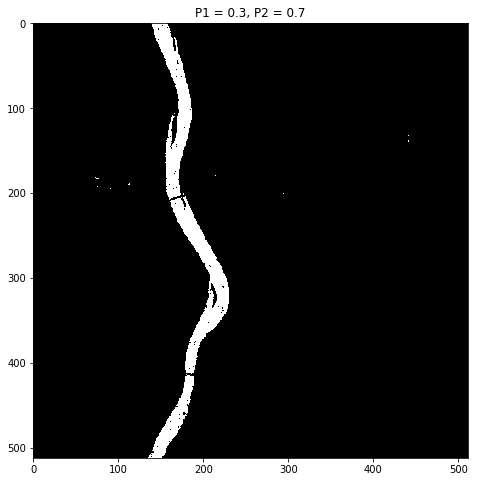

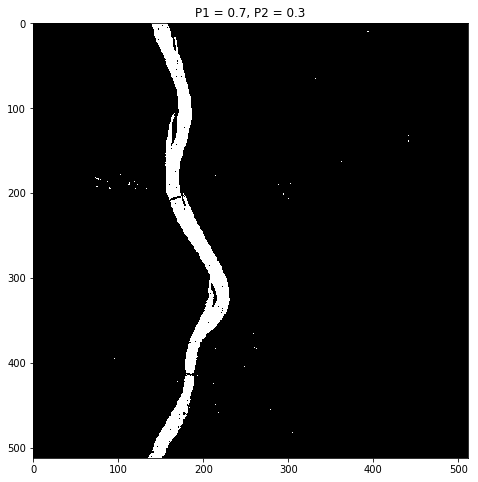

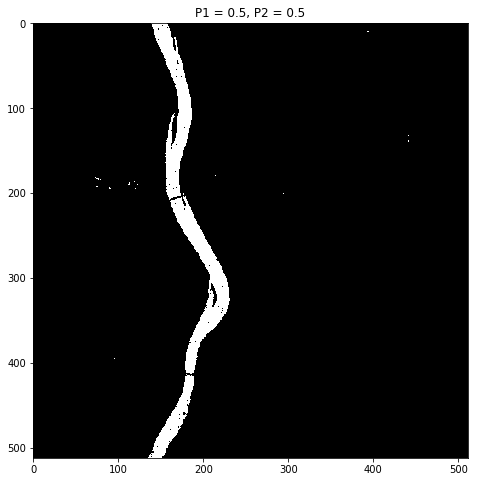

In [37]:
# Testing
P1 = [0.3,0.7,0.5]
P2 = [0.7,0.3,0.5]
for k in range(len(P1)):
    Result = np.zeros(Rchannel.shape)
    for i in range(Rchannel.shape[0]):
        for j in range(Rchannel.shape[1]):
            if Predict(i,j,P1[k],P2[k]) == 'river':
                Result[i][j] = 255
            else:
                Result[i][j] = 0

    plt.figure(figsize=(8,8))
    plt.title('P1 = ' + str(P1[k]) + ', P2 = '+str(P2[k]))
    plt.imshow(Result, cmap = 'gray')